In [1]:
import functools
import os
import numpy as np
import time
from absl import app
from absl import flags
from absl import logging

import mnist_model  # ADDED
# REMOVED from experimental.mimo import cifar_model  # local file import
import robustness_metrics as rm
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import baselines.utils_new as utils  # ADDED this!
# from uncertainty_baselines.baselines.cifar import utils
import uncertainty_metrics as um


import numpy as np
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

In [2]:
ensemble_size = 2
image_shape=[28,28,1]
width_multiplier=2 
num_classes=10
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

In [3]:

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

#model.summary()
logging.info('Model input shape: %s', model.input_shape)
logging.info('Model output shape: %s', model.output_shape)
logging.info('Model number of weights: %s', model.count_params())

In [4]:
optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)


In [5]:
checkpoint.restore(latest_checkpoint)


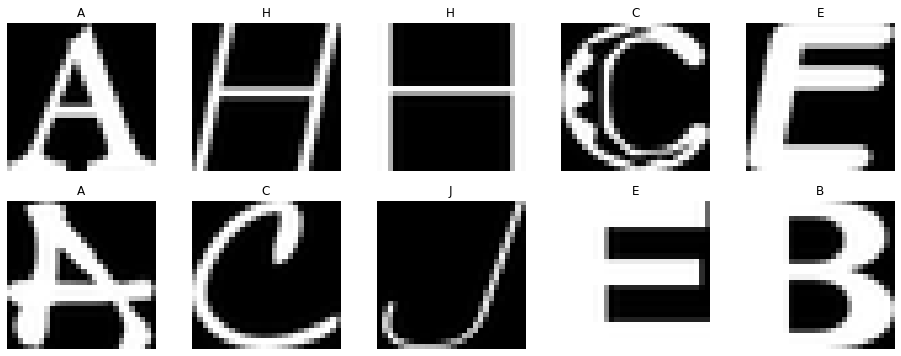

In [10]:
im_root = '/Users/benna/Desktop/DLA/dataset/notMNIST_small'
dirs = os.listdir(im_root)
fig, ax = plt.subplots(2, 5, figsize=(16, 6))

for i in range(2):
    for j in range(5):
        dr = random.choice(dirs)
        im = random.choice(os.listdir(os.path.join(im_root, dr)))
        ax[i, j].imshow(plt.imread(os.path.join(im_root, dr, im)), cmap='gray')
        ax[i, j].set_title(dr)
        ax[i, j].axis('off')

In [6]:
import imghdr
def load_not_mnist(im_root,batch_size):
    dirs = os.listdir(im_root)
    label_dict = defaultdict()

    filenames=[]
    labels=[]
    for idx, dr in enumerate(dirs):
        # print(dr)
        label_dict[idx] = dr
        ims = os.listdir(os.path.join(im_root, dr))
        random.shuffle(ims)
        for im in (ims):
            if im=="RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png" or im== "Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png":
                continue
            # # 
            # image_string = tf.io.read_file(os.path.join(im_root, dr, im))
            # try:
            #     tf.io.decode_image(image_string)
            # except:
            #     print(im)
            #     continue
            else:
                filenames.append(os.path.join(im_root, dr, im))
                labels.append(idx)
        
    filenames = tf.constant(filenames)
    labels = tf.constant(labels) 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))



    def _parse_function(filename, label):

        normalize=True
        dtype = tf.float32

        image_string = tf.io.read_file(filename)
        image = tf.io.decode_image(image_string, dtype=dtype)

        # image = tf.image.convert_image_dtype(image_decoded, dtype)
        if normalize:
            # We use the convention of mean = np.mean(train_images, axis=(0,1,2))
            # and std = np.std(train_images, axis=(0,1,2)).
            mean = tf.constant([0.1307], dtype=dtype)
            std = tf.constant([0.3081], dtype=dtype)
            # Previously, std = np.mean(np.std(train_images, axis=(1, 2)), axis=0)
            # which gave std = tf.constant([0.2023, 0.1994, 0.2010], dtype=dtype).
            # However, we change convention to use the std over the entire training
            # set instead.
            image = (image - mean) / std
        label = tf.cast(label, dtype)
        return image, label

    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


Testing on dataset %s notMNIST
(500, 2, 10)


C:\Users\benna\miniconda3\envs\DAL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


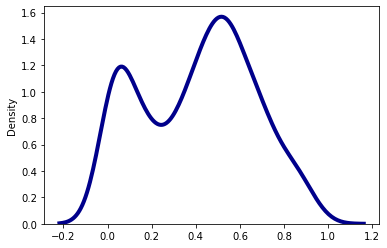

In [32]:
dataset_builder_class = ub.datasets.MnistDataset
clean_test_dataset_builder = dataset_builder_class( split=tfds.Split.TEST)
test_batch_size=500
clean_test_dataset = clean_test_dataset_builder.load(batch_size=test_batch_size)
test_datasets={}
# #test_datasets = {'clean': strategy.experimental_distribute_dataset(clean_test_dataset),}
# test_datasets = {'clean': clean_test_dataset,}

load_c_dataset = utils.load_mnist_c

# corruption_types, max_intensity = utils.load_corrupted_test_info("mnist")
# for corruption in corruption_types[:1]:
#     for intensity in range(1, max_intensity + 1):
#         dataset = load_c_dataset(
#             corruption_name=corruption,
#             corruption_intensity=intensity,
#             batch_size=test_batch_size,
#             use_bfloat16=False)

#         test_datasets['{0}_{1}'.format(corruption, intensity)] = (
#             # strategy.experimental_distribute_dataset(dataset))
#             dataset)

not_minst_root = '/Users/benna/Desktop/DLA/dataset/notMNIST_small'
not_mnist_dataset= load_not_mnist(not_minst_root,test_batch_size)
test_datasets['notMNIST'] =  not_mnist_dataset

# @tf.function
def test_step(test_iterator, dataset_name):

    # images, label = next(test_iterator).values()
    images, label = next(test_iterator)
    # print(images)
    # print(images)
    images = tf.tile(tf.expand_dims(images, 1), [1, ensemble_size, 1, 1, 1])
    logits = model(images, training=False)
    probs = tf.nn.softmax(logits)
    print(probs.shape)
    probs = tf.math.reduce_mean(probs, axis=1)  # marginalize
    # print(probs.shape)
    entr=entropy(probs,base=10,axis=1)
    # print(entr)
    # plt.hist(entr, histtype="step", align="left",bins=np.arange(-0.5,2.5,0.5))
    sns.distplot(entr, hist=False,
                 kde=True, 
             bins=5,
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
datasets_to_evaluate = test_datasets
for dataset_name, test_dataset in datasets_to_evaluate.items():
    test_iterator = iter(test_dataset)
    print('Testing on dataset %s', dataset_name)

    test_step(test_iterator, dataset_name)


In [128]:
entropy([[1,1,1,1],[1,1,1,1]],base=4,axis=1)

array([1., 1.])

In [ ]:
def step_fn(inputs):
    """Per-Replica StepFn."""
    images, labels = inputs.values()
    images = tf.tile(
        tf.expand_dims(images, 1), [1, ensemble_size, 1, 1, 1])
    logits = model(images, training=False)
    probs = tf.nn.softmax(logits)

    if dataset_name == 'clean':
        per_probs = tf.transpose(probs, perm=[1, 0, 2])
        metrics['test/diversity'].add_batch(per_probs)

    # for i in range(FLAGS.ensemble_size):
    #     member_probs = probs[:, i]
    #     member_loss = tf.keras.losses.sparse_categorical_crossentropy(
    #         labels, member_probs)
    #     metrics['test/nll_member_{}'.format(i)].update_state(member_loss)
    #     metrics['test/accuracy_member_{}'.format(i)].update_state(
    #         labels, member_probs)

    # Negative log marginal likelihood computed in a numerically-stable way.
    labels_tiled = tf.tile(
        tf.expand_dims(labels, 1), [1, FLAGS.ensemble_size])
    log_likelihoods = -tf.keras.losses.sparse_categorical_crossentropy(
        labels_tiled, logits, from_logits=True)
    negative_log_likelihood = tf.reduce_mean(
        -tf.reduce_logsumexp(log_likelihoods, axis=[1]) +
        tf.math.log(float(FLAGS.ensemble_size)))
    probs = tf.math.reduce_mean(probs, axis=1)  # marginalize

    if dataset_name == 'clean':
        metrics['test/negative_log_likelihood'].update_state(
            negative_log_likelihood)
        metrics['test/accuracy'].update_state(labels, probs)
        metrics['test/ece'].update_state(labels, probs)
    else:
        corrupt_metrics['test/nll_{}'.format(dataset_name)].update_state(
            negative_log_likelihood)
        corrupt_metrics['test/accuracy_{}'.format(dataset_name)].update_state(
            labels, probs)
        corrupt_metrics['test/ece_{}'.format(dataset_name)].update_state(
            labels, probs)